# Vibration Folder Analysis
Steve Embleton | 20161121

This notebook will explore how to create a generic program to analyize vibration data.  Using a calibration run that recorded the ESI truck vibration profile for testing purposes.

### Goals
* Import CSV data
* Find grms, zrms, Gs per sigma, Z per sigma
* Plot PSD, Transmissibility, comparisons with profiles, impact histogram (sigmas), per axis
* Output folder summary


In [1]:
%matplotlib inline

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from numpy import shape

## Import Data

In [2]:
def csv_to_data(path):
    """Given the path to a folder containing .csv files, csv_to_data reads the files and outputs
    a data variable.  Data is of the form:
    
    data = list[(event1), (event2), ... (eventn)]
    eventn = np.array([time, x, y, z], dtype=float)
    
    The subsequent programs need all the events to have the same length so I cut off the ends of
    each recording to match the smallest file.  Alternatively I could look into adding zeros to
    match the longest recording
    
    This program assumes the csv files all contain valid data.  This program also ignores the header
    of the csv file which should contain [Sample Time, X, Y, Z]"""
    
    ## Import libraries
    import glob
    import csv
    import scipy as sp
    from itertools import islice

    ## Create a list of the files in the folder
    filels = glob.glob1(path, '*.csv')

    # Initialize variables
    d = []
    data1 = [0.]*len(filels)
    datapnts = [0.]*len(filels)       # The number of points recorded in the csv file.
                                      # To compare the fft, all files need to have the 
                                      # same number of points.

    # Finds the length of each csv file
    for i in range(len(filels)):
        r = csv.reader(open(path + '\\' + filels[i]))
        datapnts[i] = len([line for line in r])


    ## Records the data file using the minimum length csv file as a limit    
    #for i in range(len(filels)):
    #    r = csv.reader(open(path + '\\' + filels[i]))
    #    data[i] = [line for line in islice(r, 1,min(datapnts))]
    #    data[i] = scipy.array(data[i], dtype=float)

    # Records the data file using the maximum length csv file as a limit    
    for i in range(len(filels)):
        r = csv.reader(open(path + '\\' + filels[i]))
        next(r, None)    # Skips the headers
        data1[i] = [line for line in r]
        data1[i] = sp.array(data1[i])

    data = sp.zeros((len(filels), max(datapnts), 4))

    for i in range(len(data1[:])):
        for j in range(len(data1[i][:,0])):
            for k in range(4):
                data[i,j,k] = float(data1[i][j,k])

    for i in range(len(data[:,0,0])):
        dt = data[i,1,0]-data[i,0,0]
        for j in range(len(data[i,:,0])-1):
            data[i,j+1,0] = data[i,j,0]+dt


    for i in range(1,4):
        data[:,:,i] = data[:,:,i] - sp.mean(data[:,:,i])
   
    return(data)

## Set folder path containing csv files
path = 'C:\\RWork\\Dell\\lattice_20170111\\logger1'
#path = 'C:\\slamstick\\Tests\\lattice_20161220\\Ch32'

data = csv_to_data(path)


In [3]:
def vib_peaks(data):
    import scipy
    
    pkx = [0]*len(data)
    pky = [0]*len(data)
    pkz = [0]*len(data)
    
    for i in range(len(data)):
        pkx[i] = max(abs(data[i,:,1]))
        pky[i] = max(abs(data[i,:,2]))
        pkz[i] = max(abs(data[i,:,3]))
    
    peaks = scipy.array([pkx, pky, pkz]).T
    
    return(peaks)

peaks = vib_peaks(data)

In [4]:
## Calculate the STD and mean of the vibration data

def vib_mean_std(peaks):
    
    N = len(peaks[0,:])             # The number of values
    
    mean = sp.mean(peaks,0)    # [mean_x, mean_y, mean_z]

    
    for i in range(N):
        std = (peaks[0,:] - mean)**2
        
    std_samp = ((1/(N-1))*std)**0.5
    std_pop = ((1/N)*std)**0.5        
    
    return(mean, std_samp, std_pop)

pks_mean, pks_std, pks_std_pop  = vib_mean_std(peaks)

## This can be calucated using sp.std(peaks, axis=0, ddof=1)
# ddof = 1 ~ sampling and ddof = 0 ~ population

In [5]:
def sigma_range(sigma, mean, std):
    
    sig_plus = mean + sigma * std
    sig_minus = mean - sigma * std
    
    return(sig_plus, sig_minus)

In [6]:
def data_to_hist(peaks):

    ## Histogram of the peak impacts from the vibration data
    import scipy
    import matplotlib.mlab as mlab
    import matplotlib.pylab as plt
    
    sig3 = scipy.array(sigma_range(3, sp.mean(peaks,0), sp.std(peaks, axis=0, ddof=1)))
    
    pkx = peaks[:,0]
    pky = peaks[:,1]
    pkz = peaks[:,2]

    # Plot Results
    plt.figure('Histogram', figsize=(8,8))
    #plt.title('Histogram of Peak Impacts On Each Axis')
    
    # Combined results
    plt.subplot(2,2,1)
    nz, binsz, patchesz = plt.hist(pkz, 30, normed=0, facecolor='green', alpha=0.50, label='Z')
    ny, binsy, patchesy = plt.hist(pky, 30, normed=0, facecolor='red', alpha=0.50, label='Y')
    nx, binsx, patchesx = plt.hist(pkx, 30, normed=0, facecolor='blue', alpha=0.50, label='X')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.ylabel('Probability')
    plt.legend(loc='upper right', fontsize = 'small')

    plt.grid(True)
    
    # Z Axis
    plt.subplot(2,2,2)
    nz, binsz, patchesz = plt.hist(pkz, 30, normed=0, facecolor='green', alpha=0.50)
    plt.plot((scipy.mean(pkz),scipy.mean(pkz)), (0, max(nz)), 'k--', linewidth=2, label=('Mean (%.2f)' % scipy.mean(pkz)))
    plt.plot((sig3[0,2],sig3[0,2]), (0, max(nz)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3[1,2], sig3[0,2])))
    plt.plot((sig3[1,2],sig3[1,2]), (1, max(nz)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    
    # X Axis
    plt.subplot(2,2,3)
    nx, binsx, patchesx = plt.hist(pkx, 30, normed=0, facecolor='blue', alpha=0.50)
    plt.plot((scipy.mean(pkx),scipy.mean(pkx)), (0, max(nx)), 'k--', linewidth=2, label=('Mean (%.2f)' % scipy.mean(pkx)))
    plt.plot((sig3[0,0],sig3[0,0]), (0, max(nx)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3[1,0], sig3[0,0])))
    plt.plot((sig3[1,0],sig3[1,0]), (1, max(nx)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.ylabel('Probability')
    plt.grid(True)
    
    # Y Axis
    plt.subplot(2,2,4)
    ny, binsy, patchesy = plt.hist(pky, 30, normed=0, facecolor='red', alpha=0.50)
    plt.plot((scipy.mean(pky),scipy.mean(pky)), (0, max(ny)), 'k--', linewidth=2, label=('Mean (%.2f)' % scipy.mean(pky)))
    plt.plot((sig3[0,1],sig3[0,1]), (0, max(ny)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3[1,1], sig3[0,1])))
    plt.plot((sig3[1,1],sig3[1,1]), (1, max(ny)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.grid(True)

    #add a best fit line curve
    #y = mlab.normpdf(bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)
    
    plt.savefig('hist_data')
    plt.show()

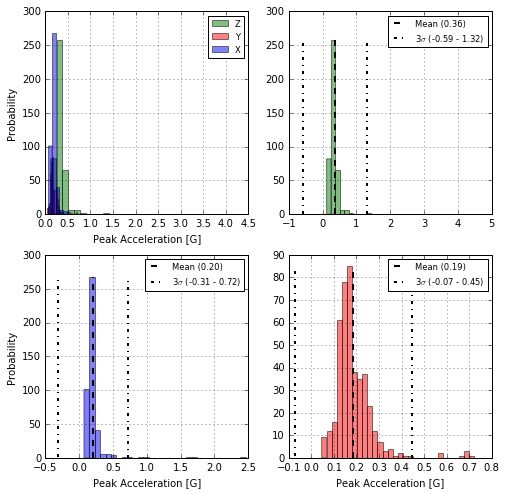

In [7]:
data_to_hist(peaks)

In [8]:
## Vibration Profiles

def vib_profiles(profile):
    import csv
    import scipy
    
    if profile == 'input_psd':
        r = csv.reader(open('C:\\python\\Vibration\\input_psd3.csv'))
        vibls = [line for line in r]
        vibls = sp.array(vibls, dtype=float).T
        vibls = vibls[:,1:].tolist()
        
        return (vibls)
    
    else:
        r = csv.reader(open('C:\\python\\Vibration\\vib_profiles.csv'))
        vibls = [line for line in r]
        vibls = scipy.array(vibls)

        for i in range(len(vibls[0,:])):
            if vibls[0,i].upper() == profile.upper():
                f = [var for var in vibls[1:,i] if var]
                p = [var for var in vibls[1:,i+1] if var]

        return([f,p])
            

In [9]:
## Transform the data into frequency domain.  G vs freq. and PSD vs freq.

def fft_data(data, printi=0):
    """Given a set of acceleration and time recordings, fft_data outputs PSD and
    frequency.  Data is input in the form:
    data = list[(event1), (event2), ... (eventn)]
    eventn = np.array([time, x, y, z], dtype=float)
    
    fft_data outputs the data in the same format as the input.
    
    """
    import scipy
    import matplotlib.pyplot as plt# Define Time
    from scipy.signal import welch
    
    ## If the time is in ms, convert to s
    if max(data[0,:,0] > 10):
        data[:,:,0] = data[:,:,0]/1000
       
    # Calculate time variables, use the same variables across all events.
    dt = (data[0,2,0] - data[0,1,0])            # Delta t, [s]
    sample_rate = 1./dt                         # Sampling rate, [Hz]
    sig_len = len(data[0,:,:])/sample_rate      # [s] Defined by recorder
    df = 1./sig_len                             # Freq. between points in freq. domain, [Hz]

    t = scipy.arange(0, sig_len, dt)            # The time vector
    n_t = len(t)                                # Length of the time vector

    # Initialize the variable to hold the FFT of the data variable.  Same format.
    data_fft = [0]*len(data)
    data_psd = [0]*len(data)

    for i in range(len(data)):
        
        sig = data[i]

        # Compute fourier transform of signal
        fx = scipy.fft(sig[1:-1,1])
        fy = scipy.fft(sig[1:-1,2])
        fz = scipy.fft(sig[1:-1,3])

        # Define frequencies
        freq = df*scipy.arange(0, len(fx), dtype='d')   # The frequency vector
        n_freq = len(freq)     
        
        data_fft[i] = scipy.array([freq, fx, fy, fz]).T
        
        # Compute the PSD of the signal
        frx, px = welch(sig[:,1], fs=sample_rate, nperseg=len(sig),
            detrend=None, scaling='density', window='hanning')
        fry, py = welch(sig[:,2], fs=sample_rate, nperseg=len(sig),
            detrend=None, scaling='density', window='hanning')
        frz, pz = welch(sig[:,3], fs=sample_rate, nperseg=len(sig),
            detrend=None, scaling='density', window='hanning')
        
        data_psd[i] = scipy.array([frx, px, py, pz]).T
    
    data_fft = scipy.array(data_fft)
    
    data_psd = sp.array(data_psd)
    
    if 1 == printi:
        # plot input data y against time
        plt.subplot(2,1,1)
        plt.plot(data[0][:,0], data[0][:,3], label='input data')
        plt.xlabel('time [s]')
        plt.ylabel('signal')

        # plot frequency spectrum
        plt.subplot(2,1,2)
        plt.loglog(data_fft[0][:,0], abs(data_fft[0][:,3]), label='abs(fourier transform)')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('abs(DFT(signal))')

        # Print plot
        plt.show()
    
    return(data_fft, data_psd)

data_fft, data_psd = fft_data(data)


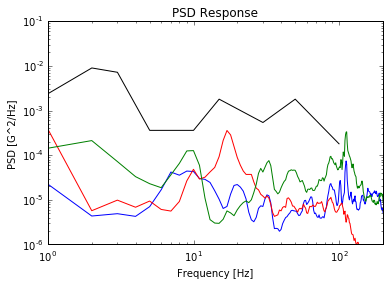

In [10]:
## Plot the average PSD response
avg_psd = sp.array([[sp.mean(data_psd[:,i,j]) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])
max_psd = sp.array([[max(abs(data_psd[:,i,j])) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])
min_psd = sp.array([[min(abs(data_psd[:,i,j])) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])

## Print Results
plt.figure('PSD')
esi_truck_profile = vib_profiles('ista air ride')
plt.loglog(esi_truck_profile[0], esi_truck_profile[1], 'k', label='Input')
plt.loglog(avg_psd[:,0], (avg_psd[:,1]), 'b', label='X')
plt.loglog(avg_psd[:,0], avg_psd[:,2], 'r', label='Y')
plt.loglog(avg_psd[:,0], (avg_psd[:,3]), 'g', label='Z')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [G^2/Hz]')
plt.title('PSD Response')
plt.axis([1,200,1e-6, 1e-1])
#plt.axis([200,1000,1e-7, 1e-2])

plt.show()

In [11]:
# Save the psd response to file if it is the input of other responses.
# This will allow for the transmissibility to be calculated.

use_input_psd = 0

if use_input_psd:
    import csv
    
    ofile = open('input_psd3.csv', 'w')
    
    writer = csv.writer(ofile, lineterminator = '\n')
    
    for row in avg_psd:
        writer.writerow(row)
    
    ofile.close()
    
    
    

In [12]:
## Interpolate values of one profile across frequency range of another response.
def vib_trans(resp, profile):
    """Interpolate the values of the profile across the frequency range of the response.  The profile consists
    of two lists, a frequency and amplitude.  The response consists of the same.  This program finds the amplitudes
    of the profile at the frequencies of the response.  This allows you to compare the amplitudes of the response 
    and the profile at the same frequencies.
    
    resp = [frequency, amplitude]
    profile = [frequency, amplitude]
    
    Returns the transmissibility results Respose / Input Profile.
    
    return([frequency, transmissibility amplitude])
    
    """

    from scipy import log10
    import scipy as sp
    
    # Convert the input from a list into an array
    resp = sp.array(resp)
    profile = sp.array(profile, dtype=float)

    m0 = []          # Finding the slope of the input profile
    for i in range(len(profile[0,:])-1):
        m0.append((log10(profile[1,i+1])-log10(profile[1,i]))/(log10(profile[0,i+1])-log10(profile[0,i])))

    freq = []        # Initialize the frequency variable
    resp_c = []      # Initialize the clipped response variable
    m = []           # Initialize the slope variable
    x1 = []          # Initialize the frequency used in the point slope equation
    y1 = []          # Initialize the amplitude used in the point slope equation

    # Find the frequencies and response where which lie within the profile frequency range
    for i in range(len(resp[0,:])):
        if resp[0,i] >= float(min(profile[0,:])) and resp[0,i] <= float(max(profile[0,:])):
            freq.append(resp[0,i])
            resp_c.append(resp[1,i])
        for j in range(len(profile[0,:])-1):
            if resp[0,i] <= profile[0,j+1] and resp[0,i] > profile[0,j]:
                m.append(m0[j])
                x1.append(profile[0,j+1])
                y1.append(profile[1,j+1])

    # Make sure the slope is recording across the appropriate values.
    if len(m)!= len(freq):
        print('Error finding slope, len(m) != len(freq)')

    resp_int = []                 # Initializing the interpolated response variable.
    # Calculating the interpolated response given the slope and input profile point
    for i in range(len(freq)):
        resp_int.append(10**(m[i]*(log10(freq[i])-log10(x1[i])) + log10(y1[i])))
    
    # Converting the list to an array
    resp_int = sp.array(resp_int)
    resp_c = sp.array(resp_c)
    
    ## From Steinberg 1988
    # P_out = Q^2 * P
    # Solving for Q ->
    trans = (resp_c/resp_int)**0.5    # Q ~ Transmissibility of system
        
    return([freq, trans])

#input_profile_label = 'input_psd'
input_profile_label = 'ista air ride'

input_profile = vib_profiles(input_profile_label)

if input_profile_label == 'input_psd':
    trans = vib_trans([avg_psd[:,0], avg_psd[:,1]], [input_profile[0], input_profile[1]])
    #transx = vib_trans([avg_psd[:,0], avg_psd[:,1]], [input_profile[0], input_profile[1]])[1]
    trans.append(vib_trans([avg_psd[:,0], avg_psd[:,2]], [input_profile[0], input_profile[2]])[1])
    trans.append(vib_trans([avg_psd[:,0], avg_psd[:,3]], [input_profile[0], input_profile[3]])[1])
    #trans = [transf, transx, transy, transz]
else:
    trans = vib_trans([avg_psd[:,0], avg_psd[:,3]], input_profile)

In [13]:
## Calculating the Grms of a shaped random vibration input curve.
# Sec. 8.8, Eqns. 8.4 - 8.6.

def grms (freq, PSD):
    """Returns the Grms value for a shaped random vibration input curve.
    Input the frequency and PSD values as a list in the form grms(freq, PSD).
    The frequency and PSD list must have the same number of elements."""
    
    from math import log10, log
    
    A = 0
    
    if len(freq)!=len(PSD):
        print("Error: The number of elements in the Frequency and PSD lists do not match.")
    
    else:
        for i in range(1,len(freq)):
            
            # Calculate the slope
            dB = 10 * log10(PSD[i]/PSD[i-1])           # dB
            OCT = log10(freq[i]/freq[i-1])/log10(2)    # Octave
            S = dB/OCT                                 # Slope
            
            # Calculate the area in units of [G^2]
            if S == 0:
                A = A + PSD[i] * (freq[i] - freq[i-1])
            elif S == -3:
                A = A + -freq[i] * PSD[i] * log(freq[i-1] / freq[i])
            else:
                A = A + (3 * PSD[i]/(3 + S)) * (freq[i] - (freq[i-1]/freq[i])**(S/3) * freq[i-1])
            
            # Calculate the Grms [G]
            grms = A**(0.5)

    return(grms)

The input GRMS is : 0.304
The response GRMS is : 0.092
Out of 432 events, the maximum impacts are 
 X : 2.46,  Y : 0.72,  Z : 4.01 [G]
The average peak impact by axis are 
 X : 0.20,  Y : 0.19,  Z : 0.36 [G]
The 3 sigma values are 
 X : 0.72,  Y : 0.45,  Z : 1.32 [G]


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars


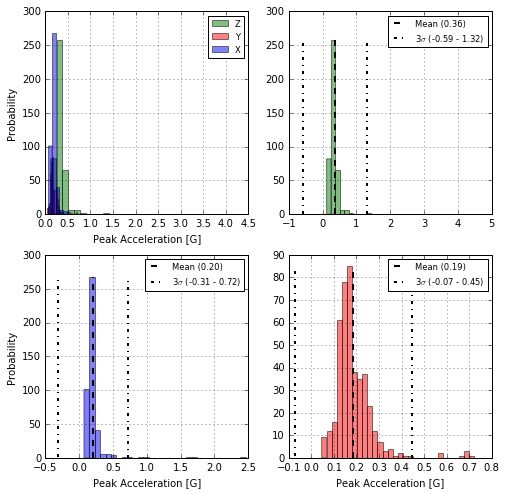

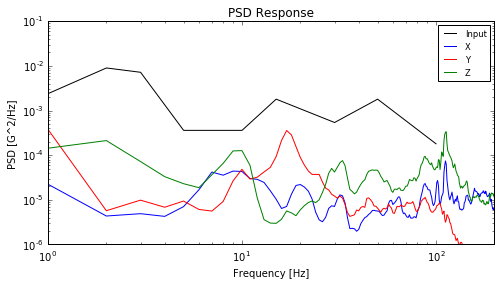

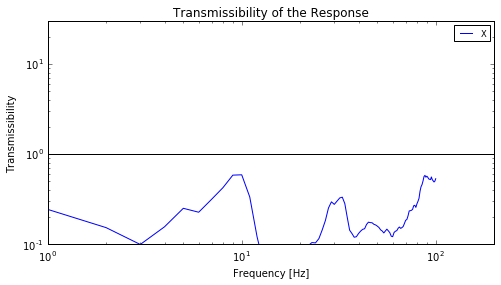

In [14]:
## Print results from the data above

print("The input GRMS is : %.3f" %(grms(sp.array(input_profile[0], dtype=float),sp.array(input_profile[1], dtype=float))))
print("The response GRMS is : %.3f" %(grms(avg_psd[:,0], avg_psd[:,3])))
print("Out of %i events, the maximum impacts are \n" %(len(data)),
      "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(max(peaks[:,0]), max(peaks[:,1]), max(peaks[:,2])))
print('The average peak impact by axis are \n',
     "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(sp.mean(peaks[:,0]), sp.mean(peaks[:,1]), sp.mean(peaks[:,2])))

sig3 = sp.array(sigma_range(3, sp.mean(peaks,0), sp.std(peaks, axis=0, ddof=1)))
print('The 3 sigma values are \n',
      "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(sig3[0,0], sig3[0,1], sig3[0,2]))

data_to_hist(peaks)

ista_air = vib_profiles('ista air ride')
plt.figure('PSD', figsize=(8,4))
if len(trans)>2:
    plt.loglog(ista_air[0], ista_air[1], 'k', label='ISTA Air (Ref)')
    plt.loglog(input_profile[0], input_profile[1], '--b', label='Input')
    plt.loglog(input_profile[0], input_profile[2], '--r', label='')
    plt.loglog(input_profile[0], input_profile[3], '--g', label='')
    plt.loglog(avg_psd[:,0], avg_psd[:,1], 'b', label='X')
    plt.loglog(avg_psd[:,0], avg_psd[:,2], 'r', label='Y')
    plt.loglog(avg_psd[:,0], avg_psd[:,3], 'g', label='Z')
else:
    plt.loglog(input_profile[0], input_profile[1], 'k', label='Input')
    plt.loglog(avg_psd[:,0], avg_psd[:,1], 'b', label='X')
    plt.loglog(avg_psd[:,0], avg_psd[:,2], 'r', label='Y')
    plt.loglog(avg_psd[:,0], avg_psd[:,3], 'g', label='Z')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [G^2/Hz]')
plt.title('PSD Response')
plt.legend(loc='best', fontsize='small')
plt.axis([1,200,1e-6, 1e-1])
plt.savefig('psd')
plt.show()

plt.figure('Trans', figsize=(8,4))
plt.loglog(trans[0], trans[1], 'b', label='X')
if len(trans)>2:
    plt.loglog(trans[0], trans[2], 'r', label='Y')
    plt.loglog(trans[0], trans[3], 'g', label='Z')
plt.legend(loc='best', fontsize='small')
plt.loglog([1, 200], [1, 1], 'k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Transmissibility')
plt.title('Transmissibility of the Response')
plt.axis([1,200,0.1,30])
plt.savefig('trans')
plt.show()


In [15]:
# Create a report
title = 'Lattice Testing 01/11/2017, Logger #1'

import docx

doc = docx.Document()

doc.add_heading('Shock and Vibration Testing', 0)
doc.add_heading(title,1)

doc.add_paragraph(text ="\nThe input GRMS is : %.3f\nThe response GRMS is : %.3f\n" 
                  %(grms(sp.array(input_profile[0], dtype=float),
                         sp.array(input_profile[1], dtype=float)), 
                    grms(avg_psd[:,0], avg_psd[:,3])))

doc.add_paragraph(('''Out of %i events, the maximum impacts are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n''') 
                  %(len(data), max(peaks[:,0]), max(peaks[:,1]), max(peaks[:,2])))
      
doc.add_paragraph('''The average peak impact by axis are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n''' 
                  %(sp.mean(peaks[:,0]), sp.mean(peaks[:,1]), sp.mean(peaks[:,2])))

doc.add_paragraph('''The 3 sigma values are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n\n''' %(sig3[0,0], sig3[0,1], sig3[0,2]))

doc.add_picture('psd.png', width=docx.shared.Inches(6), height=docx.shared.Inches(4))

#doc.paragraphs[6].runs[0].add_break(docx.enum.text.WD_BREAK.PAGE)

doc.add_picture('trans.png', width=docx.shared.Inches(6), height=docx.shared.Inches(2.5))

doc.add_paragraph('\nHistogram the peak impact accelerations and their frequency:')

doc.add_picture('hist_data.png', width=docx.shared.Inches(6), height=docx.shared.Inches(5))



doc.save('lattice_20170111-logger1.docx')

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars
